### xgboost model to predict mean player outcomes
used in conjunction with nn algs to determine mean wrc for player. Three diffrent models based on available data then combinded to create an xgb predection.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
function_dir = 'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/tools'
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')
sys.path.append(function_dir)

In [2]:
# import data
data_23_24 = pd.read_csv('./major_leauge_preds/data/cleaned/data_23_24.csv')
df = data_23_24.drop(columns=['Unnamed: 0'])
df = df.dropna()

#### Normalization



In [3]:
from tools.zscore import normalize
z_score_df = normalize(df)

### xgboost model

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

add next year wrc+ and next year PA

In [5]:
# remove 2024 to train model bc we do not know the following year
train_z = z_score_df[z_score_df['Season'] < 2024].copy()
train_z['next_wrc+'] = np.nan # empty col


for idx in train_z.index:
    # retrive name, season
    name = train_z.loc[idx, 'Name']
    season = train_z.loc[idx, 'Season']
    # full df
    next_year_noscale = df[(df['Name'] == name) & (df['Season'] == season + 1)]
    next_year_scaled = z_score_df[(z_score_df['Name'] == name) & (z_score_df['Season'] == season + 1)]

    # add to df
    if not next_year_noscale.empty:
        train_z.loc[idx, 'next_wrc+'] = next_year_noscale['wRC+'].iloc[0]
        train_z.loc[idx, 'next_pa'] = next_year_noscale['PA'].iloc[0] # need for later anaylsis

# remove rows of nas | players retired etc.
train_z = train_z.dropna(subset=['next_wrc+'])

# display
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron hicks,2023,92.730688,113.663746,115.383212,99.036504,103.436200,103.009224,103.689726,100.390931,...,90.226519,82.400047,89.911325,87.266675,87.129859,87.198924,100.121603,85.259238,19.982590,63.0
2,aaron judge,2023,100.637930,108.223069,133.579146,108.955677,100.926857,124.953327,91.050337,122.030436,...,135.841921,107.311674,144.601185,130.470781,130.291418,138.414595,117.636146,87.245085,218.425380,704.0
6,abraham toro,2023,76.970364,94.621377,102.927504,101.717114,160.099017,151.910002,99.466579,100.000972,...,139.409606,128.498197,116.441725,89.004772,95.463756,97.062008,119.706047,88.635177,86.832985,364.0
9,adam duvall,2023,94.951215,116.384085,92.515881,113.349986,100.558837,105.398179,102.826091,102.444779,...,95.832881,97.766097,110.856378,99.309199,100.830654,99.701001,108.719651,101.146009,58.048284,330.0
11,adam frazier,2023,100.475452,108.223069,95.048544,87.691006,90.724873,97.478624,104.924916,95.888314,...,95.068377,116.158793,87.816819,79.817692,81.578809,82.298585,89.931323,101.146009,63.129985,294.0


inject noise to next_pa
<br>
<small> I want to mimmic the accuracy of my projection model so that next_pa is not overweighted as a feature.

In [6]:
num_points = len(train_z['next_pa'])
noise = np.random.normal(loc=0, scale=75, size=num_points)  # corresponds to less than 0.8 std which is how much model misses on avg
train_z['next_pa'] = train_z['next_pa'] + noise
train_z['next_pa'] = train_z['next_pa'].clip(lower=10, upper=735)
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron hicks,2023,92.730688,113.663746,115.383212,99.036504,103.436200,103.009224,103.689726,100.390931,...,90.226519,82.400047,89.911325,87.266675,87.129859,87.198924,100.121603,85.259238,19.982590,214.235519
2,aaron judge,2023,100.637930,108.223069,133.579146,108.955677,100.926857,124.953327,91.050337,122.030436,...,135.841921,107.311674,144.601185,130.470781,130.291418,138.414595,117.636146,87.245085,218.425380,679.827365
6,abraham toro,2023,76.970364,94.621377,102.927504,101.717114,160.099017,151.910002,99.466579,100.000972,...,139.409606,128.498197,116.441725,89.004772,95.463756,97.062008,119.706047,88.635177,86.832985,286.841883
9,adam duvall,2023,94.951215,116.384085,92.515881,113.349986,100.558837,105.398179,102.826091,102.444779,...,95.832881,97.766097,110.856378,99.309199,100.830654,99.701001,108.719651,101.146009,58.048284,459.475757
11,adam frazier,2023,100.475452,108.223069,95.048544,87.691006,90.724873,97.478624,104.924916,95.888314,...,95.068377,116.158793,87.816819,79.817692,81.578809,82.298585,89.931323,101.146009,63.129985,293.507683


intial selection of data before feature selection

In [9]:
train_z = train_z[train_z['PA'] > 85]
X = train_z.drop(columns=['Name', 'woba', 'next_wrc+', 'player_id', 'next_pa',
                           'pa', 'bb_percent', 'k_percent', 'woba', 'BsR', 'Def',
                             'Season', 'swing_percent', 'Z-Contact%', 'O-Contact%', 'Age', 'wRC+', 'Barrel%', 'whiff_percent', 'Off'])
Y = train_z['next_wrc+']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

train test split

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

In [9]:
# corr matrix
corr = train_z.corr(numeric_only=True)

# next_wrc+ corr
corr_with_wrc = corr['next_wrc+'].sort_values(ascending=False)
print(corr_with_wrc)

next_wrc+             1.000000
next_pa               0.480811
Off                   0.385569
xwoba                 0.373123
WAR                   0.364156
avg_hyper_speed       0.345120
avg_best_speed        0.337814
maxEV                 0.327060
hard_hit_percent      0.317344
HardHit%              0.314425
PA                    0.312887
pa                    0.312887
wRC+                  0.302773
woba                  0.297832
Barrel%               0.276996
barrel_batted_rate    0.276943
bb_percent            0.157445
BB%                   0.157289
Z-Swing%              0.106650
BABIP                 0.090914
sweet_spot_percent    0.072908
Contact%              0.066968
Z-Contact%            0.057418
O-Contact%            0.046309
BsR                   0.010783
player_id            -0.004625
Age                  -0.046112
whiff_percent        -0.054794
swing_percent        -0.063604
SwStr%               -0.074378
O-Swing%             -0.103011
K%                   -0.117426
k_percen

In [11]:
model = xgb.XGBRegressor(n_jobs=-1, n_estimators=50000, device = "cuda", eval_metric = ['mae', 'rmse']) 

##### hyper para tuning

random search to narrow space into grid search

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=500, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[0]	validation_0-mae:24.92508	validation_0-rmse:35.34830
[1]	validation_0-mae:24.46480	validation_0-rmse:34.93720
[2]	validation_0-mae:23.88098	validation_0-rmse:34.15773
[3]	validation_0-mae:23.47493	validation_0-rmse:33.48034


c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[4]	validation_0-mae:23.22925	validation_0-rmse:32.98916
[5]	validation_0-mae:22.91695	validation_0-rmse:32.56357
[6]	validation_0-mae:22.88390	validation_0-rmse:32.41213
[7]	validation_0-mae:23.03598	validation_0-rmse:32.57960
[8]	validation_0-mae:22.94525	validation_0-rmse:32.30197
[9]	validation_0-mae:22.78709	validation_0-rmse:31.90849
[10]	validation_0-mae:22.79153	validation_0-rmse:31.80691
[11]	validation_0-mae:22.55503	validation_0-rmse:31.23122
[12]	validation_0-mae:22.58210	validation_0-rmse:31.21284
[13]	validation_0-mae:22.68379	validation_0-rmse:31.28382
[14]	validation_0-mae:22.50479	validation_0-rmse:30.92757
[15]	validation_0-mae:22.45642	validation_0-rmse:30.93501
[16]	validation_0-mae:22.35599	validation_0-rmse:30.62405
[17]	validation_0-mae:22.39897	validation_0-rmse:30.55738
[18]	validation_0-mae:22.42082	validation_0-rmse:30.41678
[19]	validation_0-mae:22.48504	validation_0-rmse:30.58431
[20]	validation_0-mae:22.53240	validation_0-rmse:30.70543
[21]	validation_0-ma

grid search

In [13]:
from sklearn.model_selection import GridSearchCV
grid_search_params = {
    'learning_rate': [0.05, 0.1, 0.15],   
    'max_leaves': [10, 15, 20, 25],
    'min_child_weight': [10, 15, 20],      
    'subsample': [0.3, 0.4, 0.5],           
    'colsample_bytree':[0.4, 0.5, 0.6],     
    'early_stopping_rounds':[10, 20, 30],
    'max_depth': [2, 3, 4]
}

In [14]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[0]	validation_0-mae:25.65964	validation_0-rmse:36.18203
[1]	validation_0-mae:25.38488	validation_0-rmse:35.86109
[2]	validation_0-mae:25.06731	validation_0-rmse:35.43523
[3]	validation_0-mae:24.79722	validation_0-rmse:35.10348
[4]	validation_0-mae:24.54276	validation_0-rmse:34.81199
[5]	validation_0-mae:24.34872	validation_0-rmse:34.55046
[6]	validation_0-mae:24.22967	validation_0-rmse:34.42131
[7]	validation_0-mae:24.04840	validation_0-rmse:34.16416
[8]	validation_0-mae:23.77185	validation_0-rmse:33.79450
[9]	validation_0-mae:23.66808	validation_0-rmse:33.59128
[10]	validation_0-mae:23.59688	validation_0-rmse:33.47560
[11]	validation_0-mae:23.34241	validation_0-rmse:33.07829
[12]	validation_0-mae:23.09886	validation_0-rmse:32.70214
[13]	validation_0-mae:23.08662	validation_0-rmse:32.72103
[14]	validation_0-mae:22.89875	validation_0-rmse:32.47989
[15]	validation_0-mae:22.74488	validation_0-rmse:32.25153
[16]	validation_

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:00:56] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[29]	validation_0-mae:21.87411	validation_0-rmse:30.81019
[30]	validation_0-mae:21.89655	validation_0-rmse:30.80858
[31]	validation_0-mae:21.91581	validation_0-rmse:30.74656
[32]	validation_0-mae:21.93878	validation_0-rmse:30.69072
[33]	validation_0-mae:21.89991	validation_0-rmse:30.55722
[34]	validation_0-mae:21.85721	validation_0-rmse:30.49909
[35]	validation_0-mae:21.82987	validation_0-rmse:30.40735
[36]	validation_0-mae:21.83029	validation_0-rmse:30.37794
[37]	validation_0-mae:21.81789	validation_0-rmse:30.39824
[38]	validation_0-mae:21.87301	validation_0-rmse:30.44248
[39]	validation_0-mae:21.89030	validation_0-rmse:30.38572
[40]	validation_0-mae:21.82913	validation_0-rmse:30.31908
[41]	validation_0-mae:21.74959	validation_0-rmse:30.23913
[42]	validation_0-mae:21.79425	validation_0-rmse:30.28474
[43]	validation_0-mae:21.92234	validation_0-rmse:30.39452
[44]	validation_0-mae:21.90007	validation_0-rmse:30.35467
[45]	validation_0-mae:21.86375	validation_0-rmse:30.33952
[46]	validatio

In [12]:
opti_para = {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 7, 'min_child_weight': 10, 'subsample': 0.6}
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

xgb.cv for detailed analysis, optimal boosting rounds

In [24]:
matrix_data = xgb.DMatrix(X, Y)
fmodel = xgb.cv(opti_para, dtrain=matrix_data, num_boost_round=1000, nfold=10, metrics= ['rmse', 'mae'], as_pandas=True, seed=26, early_stopping_rounds=30)
fmodel.head()

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:48] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,35.863739,0.250006,26.382566,0.201534,36.007054,2.217329,26.494172,1.815920
1,35.484805,0.271481,26.085373,0.196348,35.805761,2.286888,26.319268,1.931158
2,34.951803,0.263823,25.681785,0.192127,35.347929,2.301256,25.935860,1.957852
3,34.435393,0.251371,25.304327,0.183403,34.962472,2.351258,25.628980,2.002572
4,34.099230,0.254396,25.041328,0.178068,34.768571,2.425812,25.470811,2.097580


#### opti model

In [13]:
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [14]:
model.set_params(n_estimators=50, early_stopping_rounds=None)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:40] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


##### Results DF

In [15]:
results_df = xtest.copy()
results_df['Name'] = train_z.loc[xtest.index, 'Name']
results_df['Season'] = train_z.loc[xtest.index, 'Season']
results_df['next_pa'] = train_z.loc[xtest.index, 'next_pa']
results_df['pred_wrc+'] = ypreds
results_df['season_plus1_wrc+'] = ytest
results_df = results_df[['Name', 'Season', 'pred_wrc+', 'season_plus1_wrc+', 'next_pa']]
results_df['miss'] = (results_df['season_plus1_wrc+'] - results_df['pred_wrc+']).abs()
results_df.head()

,Name,Season,pred_wrc+,season_plus1_wrc+,next_pa,miss
1001,reese mcguire,2023,60.354179,59.856632,144.412227,0.497547
221,chas mccormick,2023,98.984718,66.076152,179.641306,32.908566
84,austin hays,2023,88.581627,97.833915,276.978697,9.252288
994,ramon urias,2023,79.648506,115.218031,453.602736,35.569525
555,jeremy pena,2023,99.569221,99.919401,578.412380,0.350180


##### Model Eval

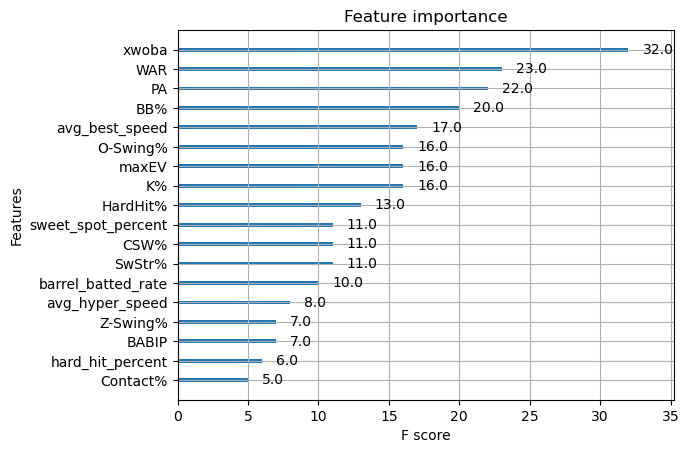

In [16]:
xgb.plot_importance(model)
plt.show()

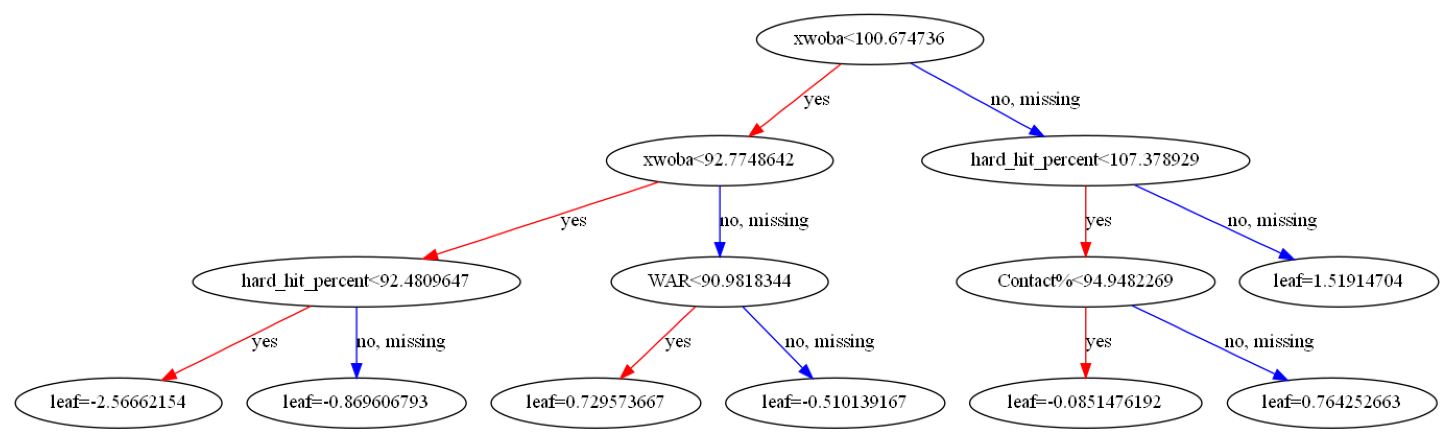

In [17]:
xgb.plot_tree(model)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### Metrics

In [18]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2 = r2_score(y_true=ytest, y_pred=ypreds)
mae = mean_absolute_error(y_true=ytest, y_pred=ypreds)
rmse = root_mean_squared_error(y_true=ytest, y_pred=ypreds)

print(f"R^2: {r2} \n mse: {mae} \n rmse: {rmse}")

R^2: 0.1940795488663789 
 mse: 21.13799986295715 
 rmse: 27.976221470467856


#### 2025 Predections

prepare data, import next_pa

In [20]:
season = z_score_df[z_score_df['Season'] >= 2024].copy()
season = season.reset_index()
season = season.drop(columns=['index'])

In [21]:
season_pred = season.drop(columns=['Name', 'woba', 'player_id',
                           'pa', 'bb_percent', 'k_percent', 'woba', 'BsR', 'Def',
                             'Season', 'swing_percent', 'Z-Contact%', 'O-Contact%', 'Age', 'wRC+', 'Barrel%', 'whiff_percent', 'Off'])

In [22]:
preds_2025 = model.predict(season_pred)
preds_2025 = pd.DataFrame(preds_2025)
preds_2025['Name'] = season['Name']
preds_2025

,0,Name
0,72.277473,aaron hicks
1,131.996307,aaron judge
2,68.025833,aaron schunk
3,82.211937,abraham toro
4,54.169029,adael amador
...,...,...
602,81.372849,zach mckinstry
603,101.937355,zach neto
604,69.139915,zach remillard
605,75.594849,zack gelof


In [23]:
preds_2025.to_csv('./major_leauge_preds/predicted_data/wrc_pred/reg_23_preds.csv')